In [1]:
import pandas as pd
import sys
# Path to the directory just above 'Code'
sys.path.append('/Users/maxguo/Desktop/TS_Forecasting_Project')
from Code.Load import Loaded_Data_v2 as ld
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor

/Users/maxguo/Desktop/TS_Forecasting_Project/Code/Load/Loaded_Data_v2.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined['inverse_sizerank'] = 1 / filtered_combined['sizerank']
/Users/maxguo/Desktop/TS_Forecasting_Project/Code/Load/Loaded_Data_v2.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined['inverse_sizerank'] = 1 / filtered_combined['sizerank']
/Users/maxguo/Desktop/TS_Forecasting_Project/Code/Load/Loaded_Data_v2.py:59: SettingWithCopyWarning: 
A value is tryin

### Simple Model

In [2]:
weighted_regional = ld.regional_grouped_data
weighted_regional = weighted_regional.reset_index()
weighted_regional
data = weighted_regional
data

,index,region,date,w_new construction sales count,w_new construction mean sales price ($),w_mean price cut ($),w_mean days to pending,w_mean price cut (%),w_median sales price ($),w_mean sales price ($),w_percent sold above list (%),w_zillow home value index,w_zillow observed rent index,Population,w_PCPI,MORTGAGE30US,UMCSENT
0,0,Midwest,2018-03-31,12082.313315,4.064101e+05,10538.410409,52.052799,0.036359,169720.672511,214909.413629,0.193328,177917.042559,1158.106957,68282.287000,50734.507055,4.4675,98.8
1,1,Midwest,2018-04-30,13163.086629,4.605180e+05,10953.848964,46.659460,0.035415,174924.090647,216956.793549,0.223797,179069.593324,1161.130432,68288.709667,50870.816130,4.5860,98.0
2,2,Midwest,2018-05-31,14303.497230,4.708800e+05,11251.988743,41.784847,0.034718,180567.276454,221728.396186,0.256569,180050.664394,1161.447113,68295.132333,51007.127406,4.5700,98.2
3,3,Midwest,2018-06-30,14972.297595,4.494060e+05,11314.173614,39.344523,0.034203,186045.884185,228385.708537,0.277426,180559.091498,1164.915058,68301.555000,51143.440884,4.5275,97.9
4,4,Midwest,2018-07-31,15543.400245,4.417524e+05,11156.103439,39.189459,0.034224,188284.757964,230886.550933,0.279945,181081.408745,1167.620911,68307.977667,51279.756562,4.5500,96.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,227,West,2022-08-31,11208.192986,1.339130e+06,39243.904002,26.274381,0.037712,681054.710026,853524.899987,0.475217,722972.461519,2325.079119,78851.038667,73319.024110,6.1120,58.6
228,228,West,2022-09-30,11360.191915,1.326951e+06,36886.907615,31.836967,0.036386,667081.443379,834104.611750,0.381116,700496.291310,2329.133220,78862.480250,73598.624379,6.9000,59.9
229,229,West,2022-10-31,11108.923026,1.340645e+06,36423.384805,36.651533,0.035881,659426.795421,825012.638395,0.323425,707996.611497,2331.012486,78873.921833,73878.221654,6.8050,56.7
230,230,West,2022-11-30,10445.967318,1.257429e+06,36331.386946,40.871661,0.035924,650854.904059,816643.441122,0.293027,702691.058671,2332.224444,78885.363417,74157.815934,6.3640,59.8


/var/folders/n4/gxgjq2d52n1gzz_0x_mtj72r0000gn/T/ipykernel_89532/426375144.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['date'] = pd.to_datetime(data_filtered['date'])


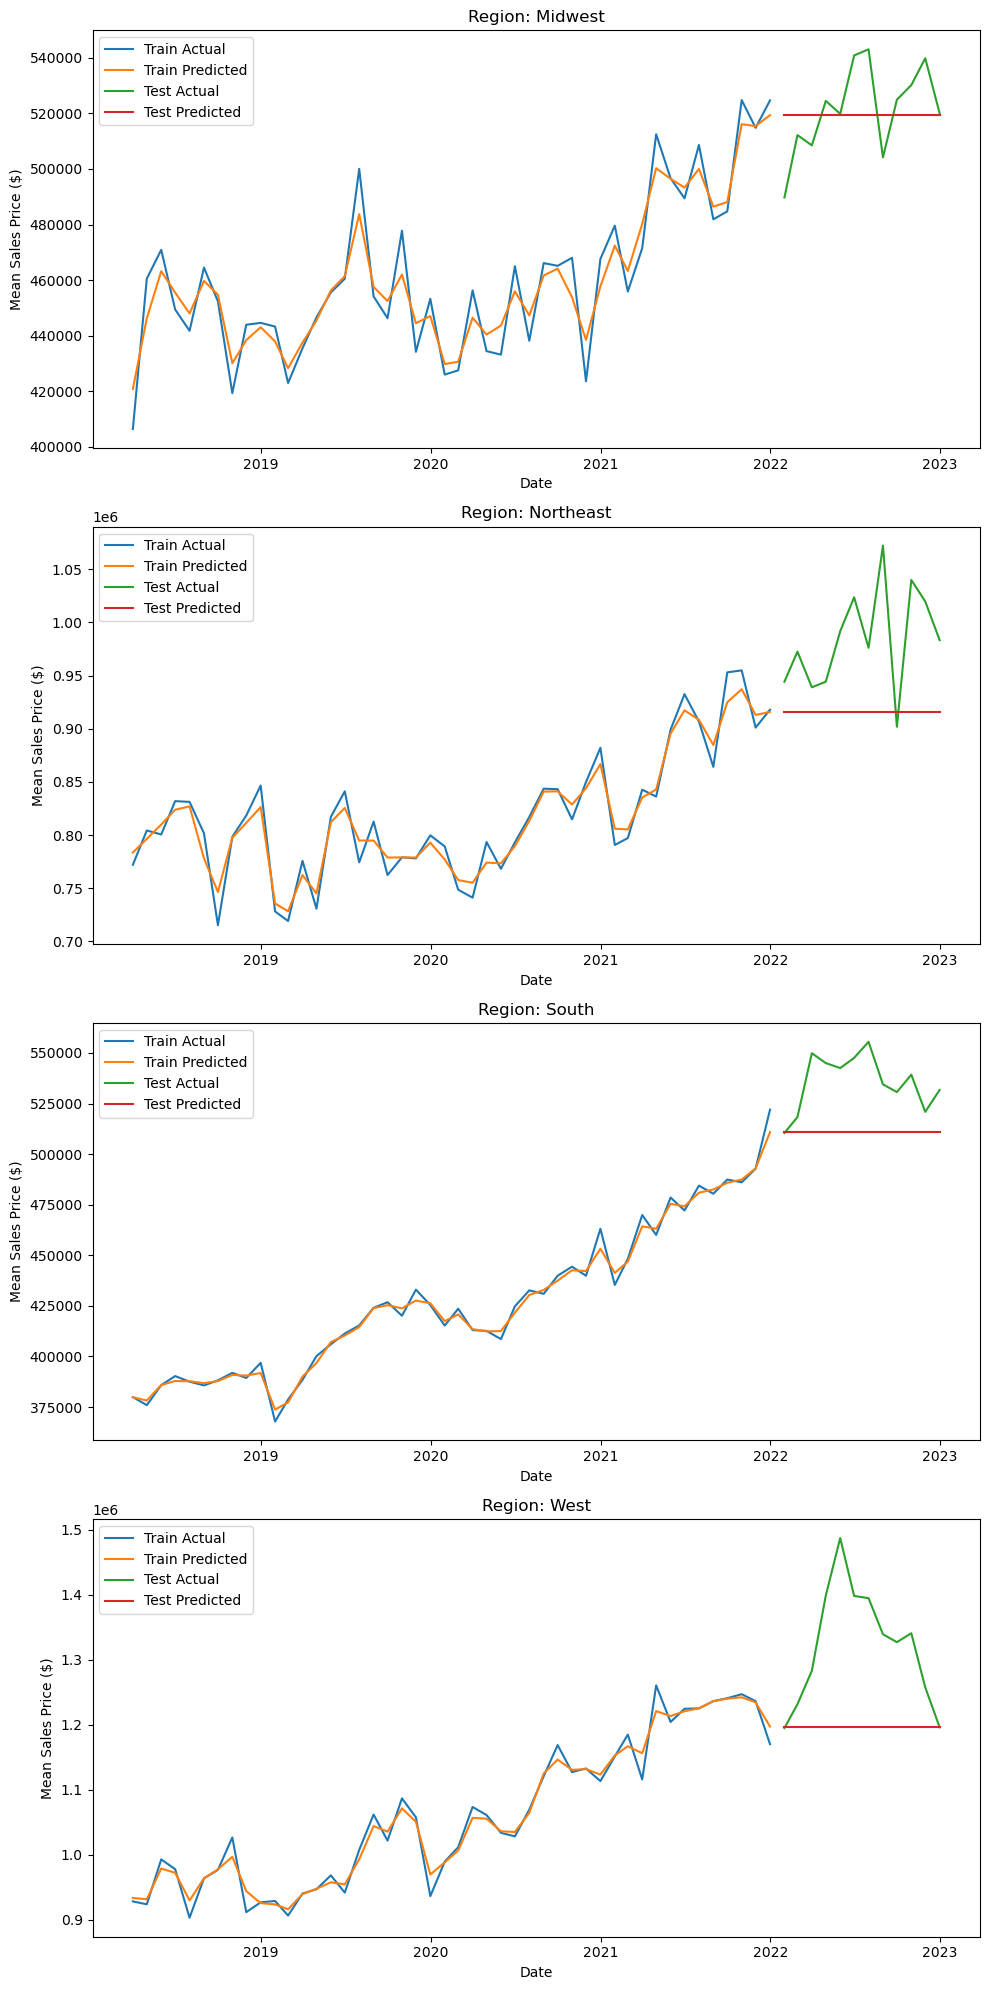

In [3]:
# Filter relevant columns
data_filtered = data[['region', 'date', 'w_new construction mean sales price ($)']]
data_filtered['date'] = pd.to_datetime(data_filtered['date'])

# Prepare data for each region separately
regions = data_filtered['region'].unique()

# Initialize a dictionary to store results
results = {}

for region in regions:
    region_data = data_filtered[data_filtered['region'] == region].copy()
    region_data.set_index('date', inplace=True)
    
    # Split data into features and target
    X = region_data.index
    y = region_data['w_new construction mean sales price ($)']
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Convert datetime index to ordinal for modeling
    X_train_ordinal = X_train.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    X_test_ordinal = X_test.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train_ordinal, y_train)
    
    # Make forecasts
    y_pred_train = model.predict(X_train_ordinal)
    y_pred_test = model.predict(X_test_ordinal)
    
    # Store results
    results[region] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }

# Plot results for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 5 * len(regions)))
if len(regions) == 1:
    axes = [axes]

for ax, region in zip(axes, regions):
    result = results[region]
    ax.plot(result['X_train'], result['y_train'], label='Train Actual')
    ax.plot(result['X_train'], result['y_pred_train'], label='Train Predicted')
    ax.plot(result['X_test'], result['y_test'], label='Test Actual')
    ax.plot(result['X_test'], result['y_pred_test'], label='Test Predicted')
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sales Price ($)')
    ax.legend()

plt.tight_layout()
plt.show()

/var/folders/n4/gxgjq2d52n1gzz_0x_mtj72r0000gn/T/ipykernel_89532/3006020291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_mean_sales['date'] = pd.to_datetime(data_filtered_mean_sales['date'])


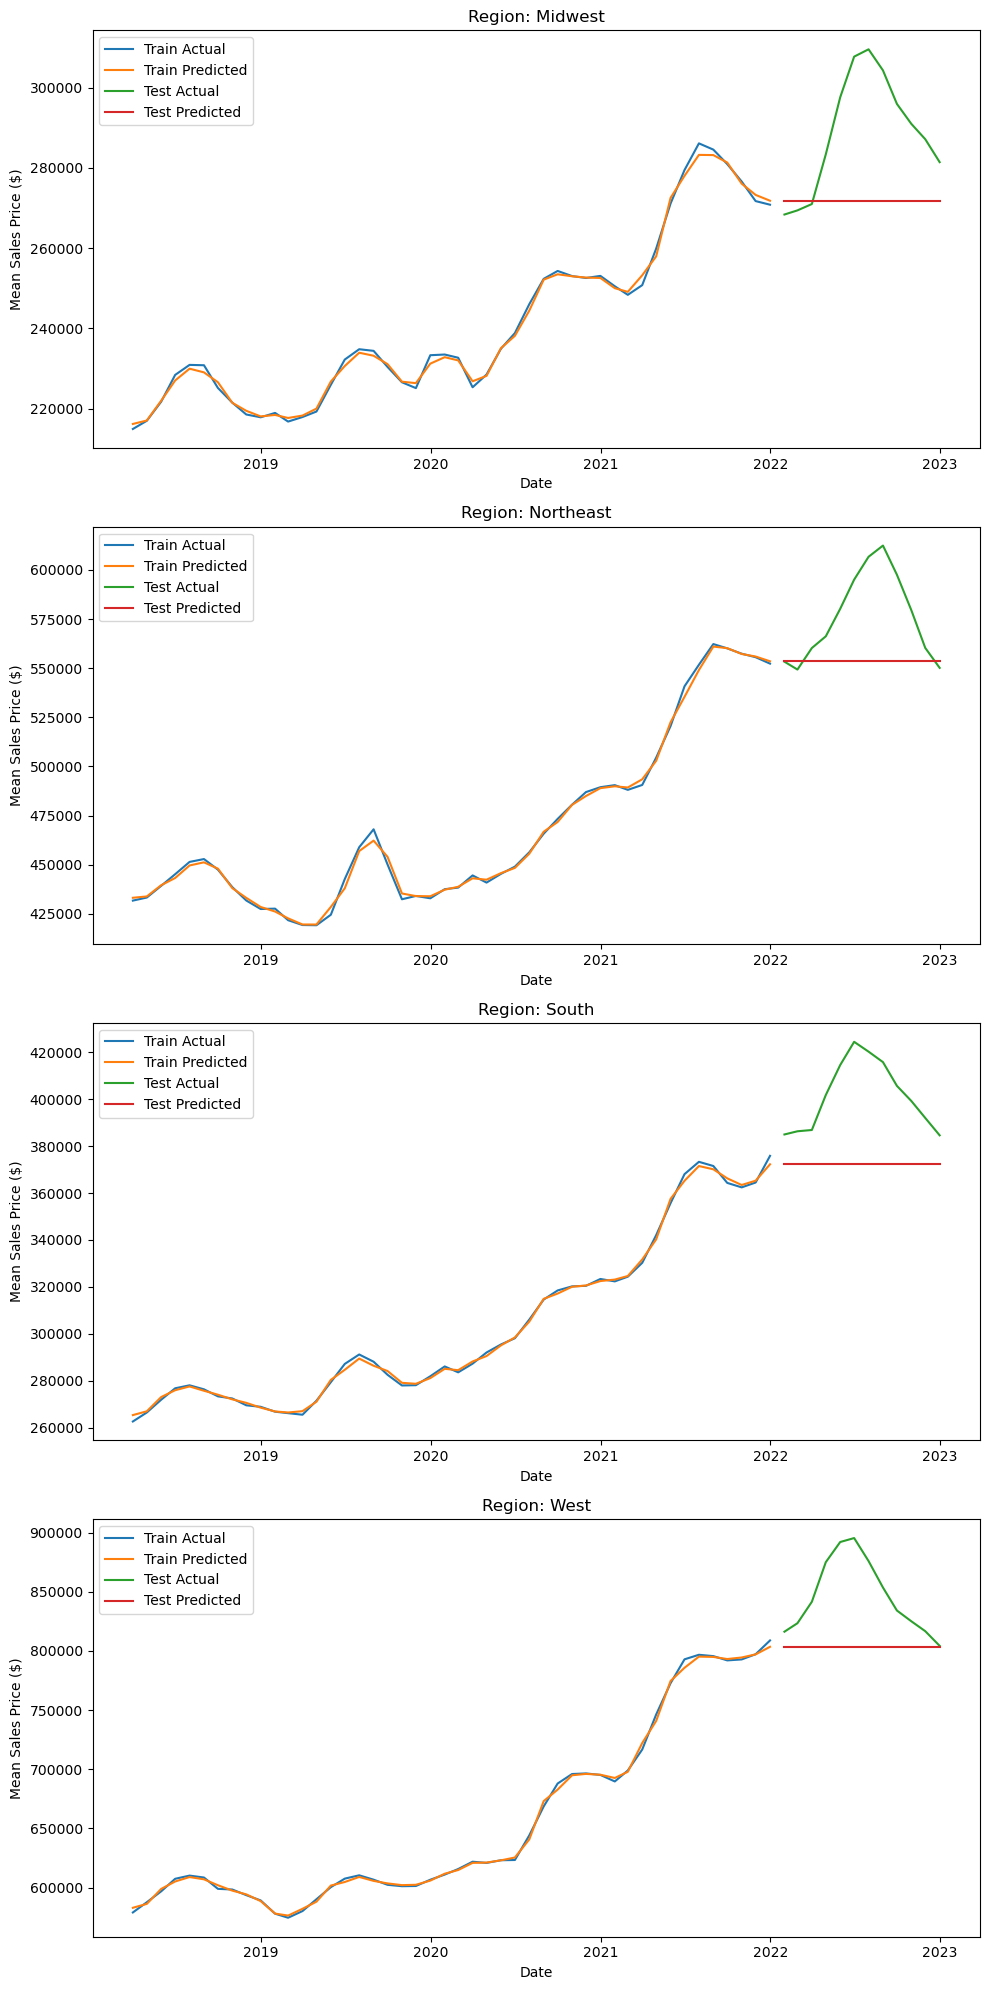

In [4]:
# Filter relevant columns for w_mean sales price ($)
data_filtered_mean_sales = data[['region', 'date', 'w_mean sales price ($)']]
data_filtered_mean_sales['date'] = pd.to_datetime(data_filtered_mean_sales['date'])

# Initialize a dictionary to store results for Random Forest model
rf_results = {}

for region in regions:
    region_data = data_filtered_mean_sales[data_filtered_mean_sales['region'] == region].copy()
    region_data.set_index('date', inplace=True)
    
    # Split data into features and target
    X = region_data.index
    y = region_data['w_mean sales price ($)']
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Convert datetime index to ordinal for modeling
    X_train_ordinal = X_train.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    X_test_ordinal = X_test.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train_ordinal, y_train)
    
    # Make forecasts
    y_pred_train = model.predict(X_train_ordinal)
    y_pred_test = model.predict(X_test_ordinal)
    
    # Store results
    rf_results[region] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }

# Plot results for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 5 * len(regions)))
if len(regions) == 1:
    axes = [axes]

for ax, region in zip(axes, regions):
    result = rf_results[region]
    ax.plot(result['X_train'], result['y_train'], label='Train Actual')
    ax.plot(result['X_train'], result['y_pred_train'], label='Train Predicted')
    ax.plot(result['X_test'], result['y_test'], label='Test Actual')
    ax.plot(result['X_test'], result['y_pred_test'], label='Test Predicted')
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sales Price ($)')
    ax.legend()

plt.tight_layout()
plt.show()


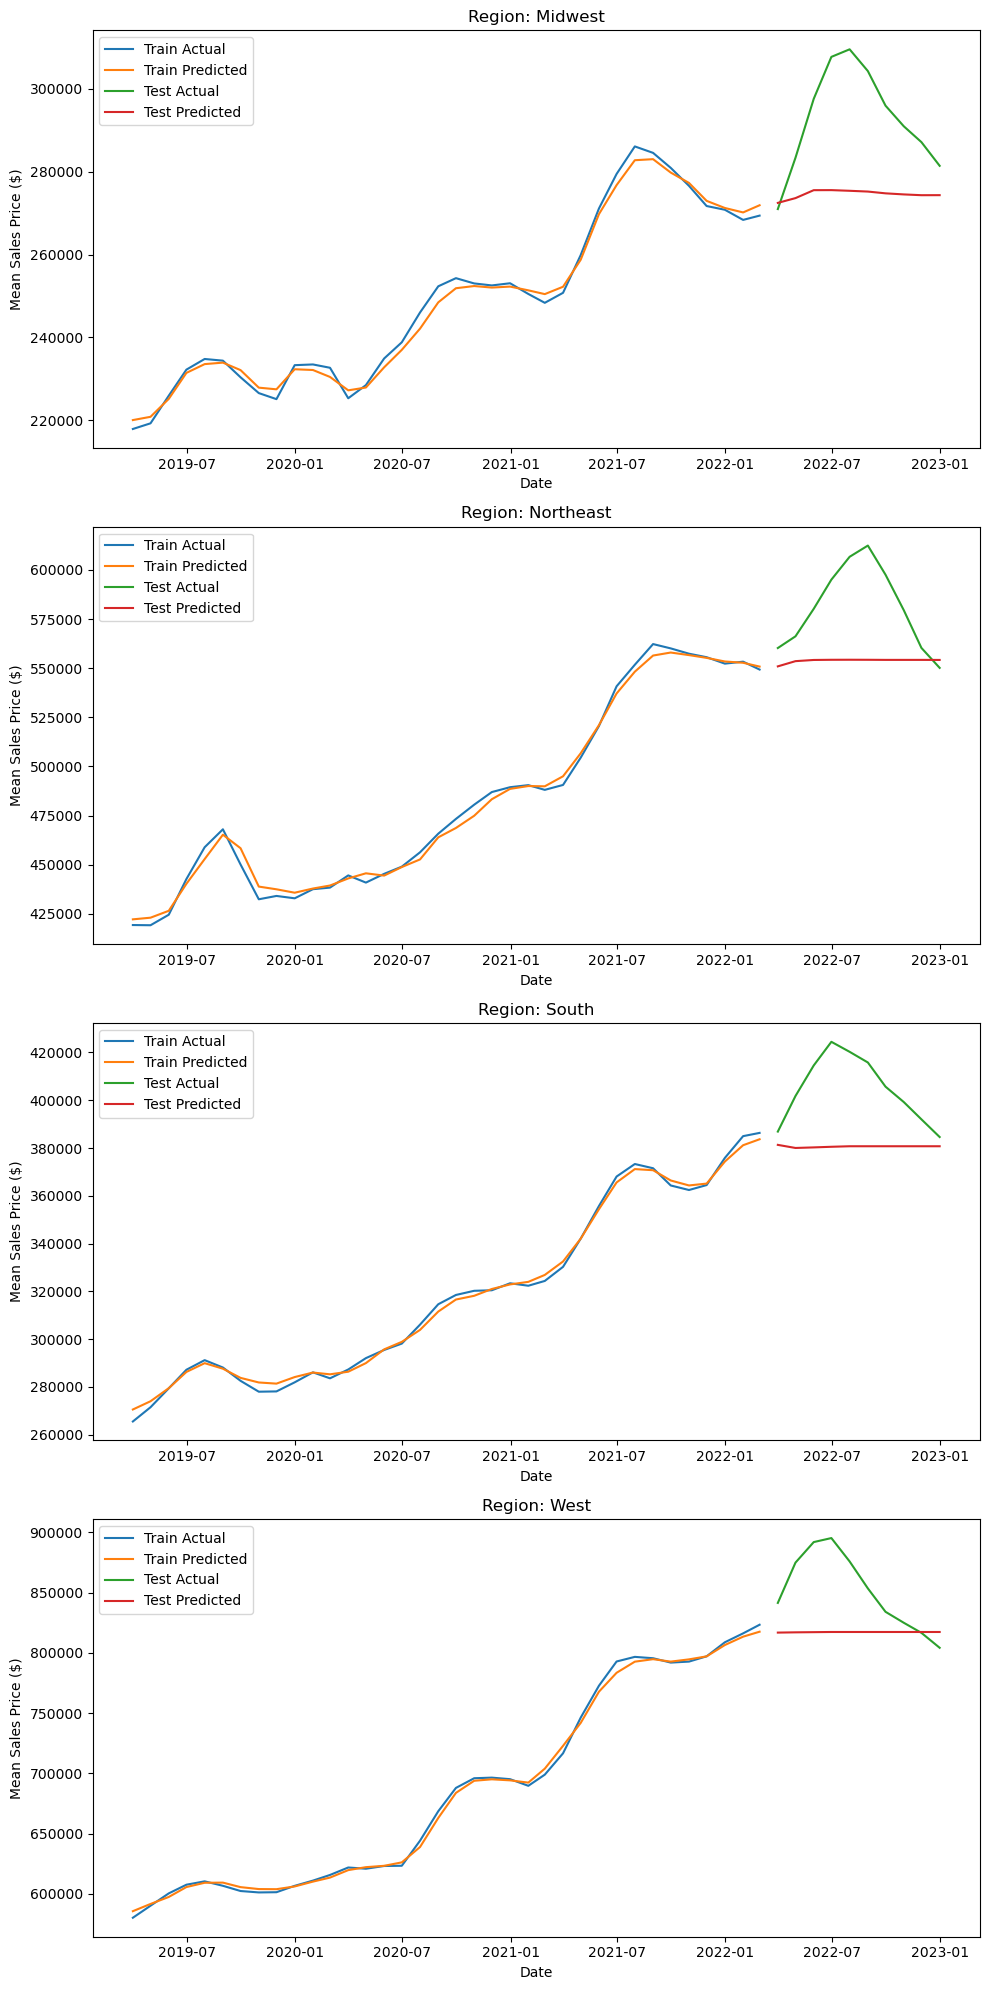

In [5]:
# Function to create lag features
def create_lag_features(data, target_column, lags=12):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df.dropna(inplace=True)
    return df

# Initialize a dictionary to store results for Random Forest model with lag features
rf_lag_results = {}

# Parameters
lags = 12
test_size = 0.2

for region in regions:
    region_data = data_filtered_mean_sales[data_filtered_mean_sales['region'] == region].copy()
    region_data.set_index('date', inplace=True)
    
    # Create lag features
    region_data_lagged = create_lag_features(region_data, target_column='w_mean sales price ($)', lags=lags)
    
    # Split data into features and target
    X = region_data_lagged.drop(['w_mean sales price ($)', 'region'], axis=1)
    y = region_data_lagged['w_mean sales price ($)']
    
    # Split data into training and test sets
    train_size = int(len(region_data_lagged) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    
    # Make forecasts
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Store results
    rf_lag_results[region] = {
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'X_train': X_train.index,
        'X_test': X_test.index
    }

# Plot results for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 5 * len(regions)))
if len(regions) == 1:
    axes = [axes]

for ax, region in zip(axes, regions):
    result = rf_lag_results[region]
    ax.plot(result['X_train'], result['y_train'], label='Train Actual')
    ax.plot(result['X_train'], result['y_pred_train'], label='Train Predicted')
    ax.plot(result['X_test'], result['y_test'], label='Test Actual')
    ax.plot(result['X_test'], result['y_pred_test'], label='Test Predicted')
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sales Price ($)')
    ax.legend()

plt.tight_layout()
plt.show()


00:38:27 - cmdstanpy - INFO - Chain [1] start processing
00:38:27 - cmdstanpy - INFO - Chain [1] done processing
00:38:28 - cmdstanpy - INFO - Chain [1] start processing
00:38:28 - cmdstanpy - INFO - Chain [1] done processing
00:38:28 - cmdstanpy - INFO - Chain [1] start processing
00:38:28 - cmdstanpy - INFO - Chain [1] done processing
00:38:28 - cmdstanpy - INFO - Chain [1] start processing
00:38:29 - cmdstanpy - INFO - Chain [1] done processing


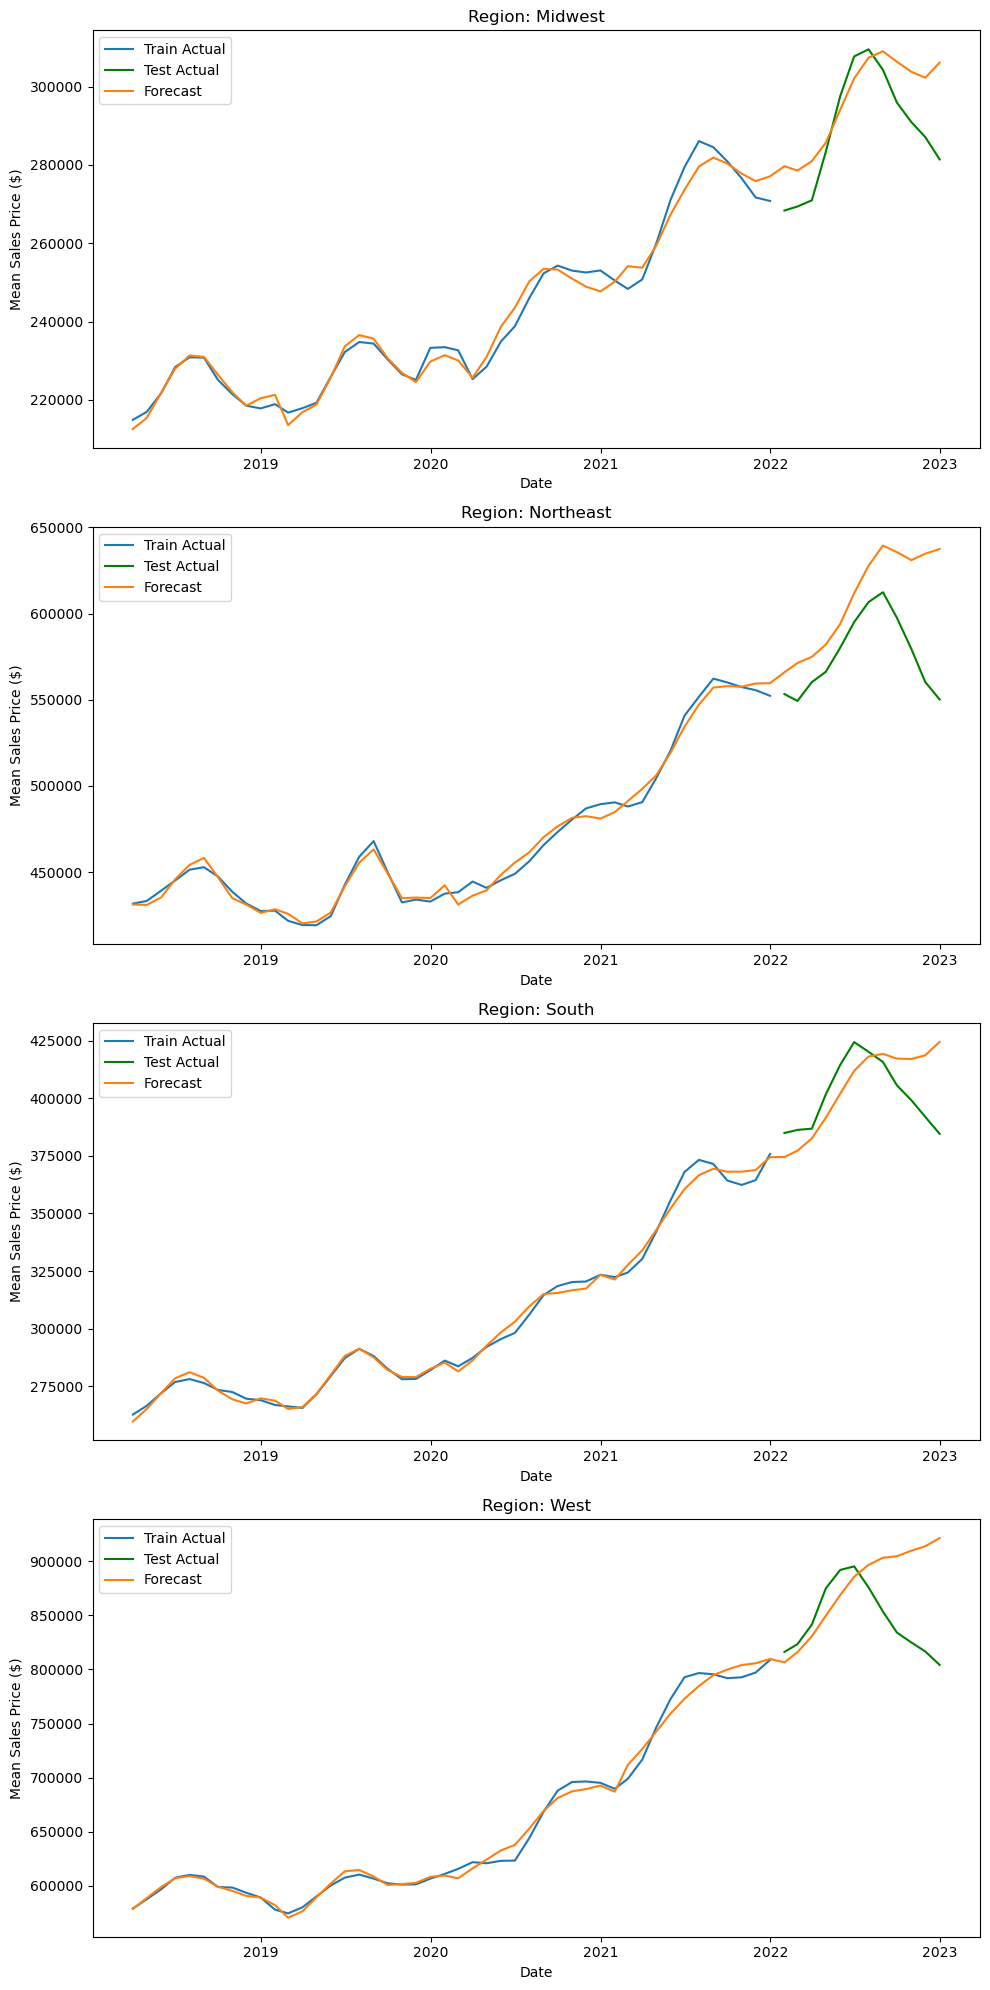

In [6]:
from prophet import Prophet

# Initialize a dictionary to store results for Prophet model
prophet_results = {}

# Parameters
test_size = 0.2

# Prepare data for each region separately
for region in regions:
    region_data = data_filtered_mean_sales[data_filtered_mean_sales['region'] == region].copy()
    
    # Prepare the data for Prophet
    region_data_prophet = region_data.rename(columns={'date': 'ds', 'w_mean sales price ($)': 'y'})
    
    # Split data into training and test sets
    train_size = int(len(region_data_prophet) * (1 - test_size))
    train_data = region_data_prophet[:train_size]
    test_data = region_data_prophet[train_size:]
    
    # Initialize and train the model
    model = Prophet()
    model.fit(train_data)
    
    # Make future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_data), freq='M')
    forecast = model.predict(future)
    
    # Store results
    prophet_results[region] = {
        'train': train_data,
        'test': test_data,
        'forecast': forecast,
        'future': future
    }

# Plot results for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 5 * len(regions)))
if len(regions) == 1:
    axes = [axes]

for ax, region in zip(axes, regions):
    result = prophet_results[region]
    ax.plot(result['train']['ds'], result['train']['y'], label='Train Actual')
    ax.plot(result['test']['ds'], result['test']['y'], label='Test Actual', color='green')
    ax.plot(result['forecast']['ds'], result['forecast']['yhat'], label='Forecast')
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sales Price ($)')
    ax.legend()

plt.tight_layout()
plt.show()


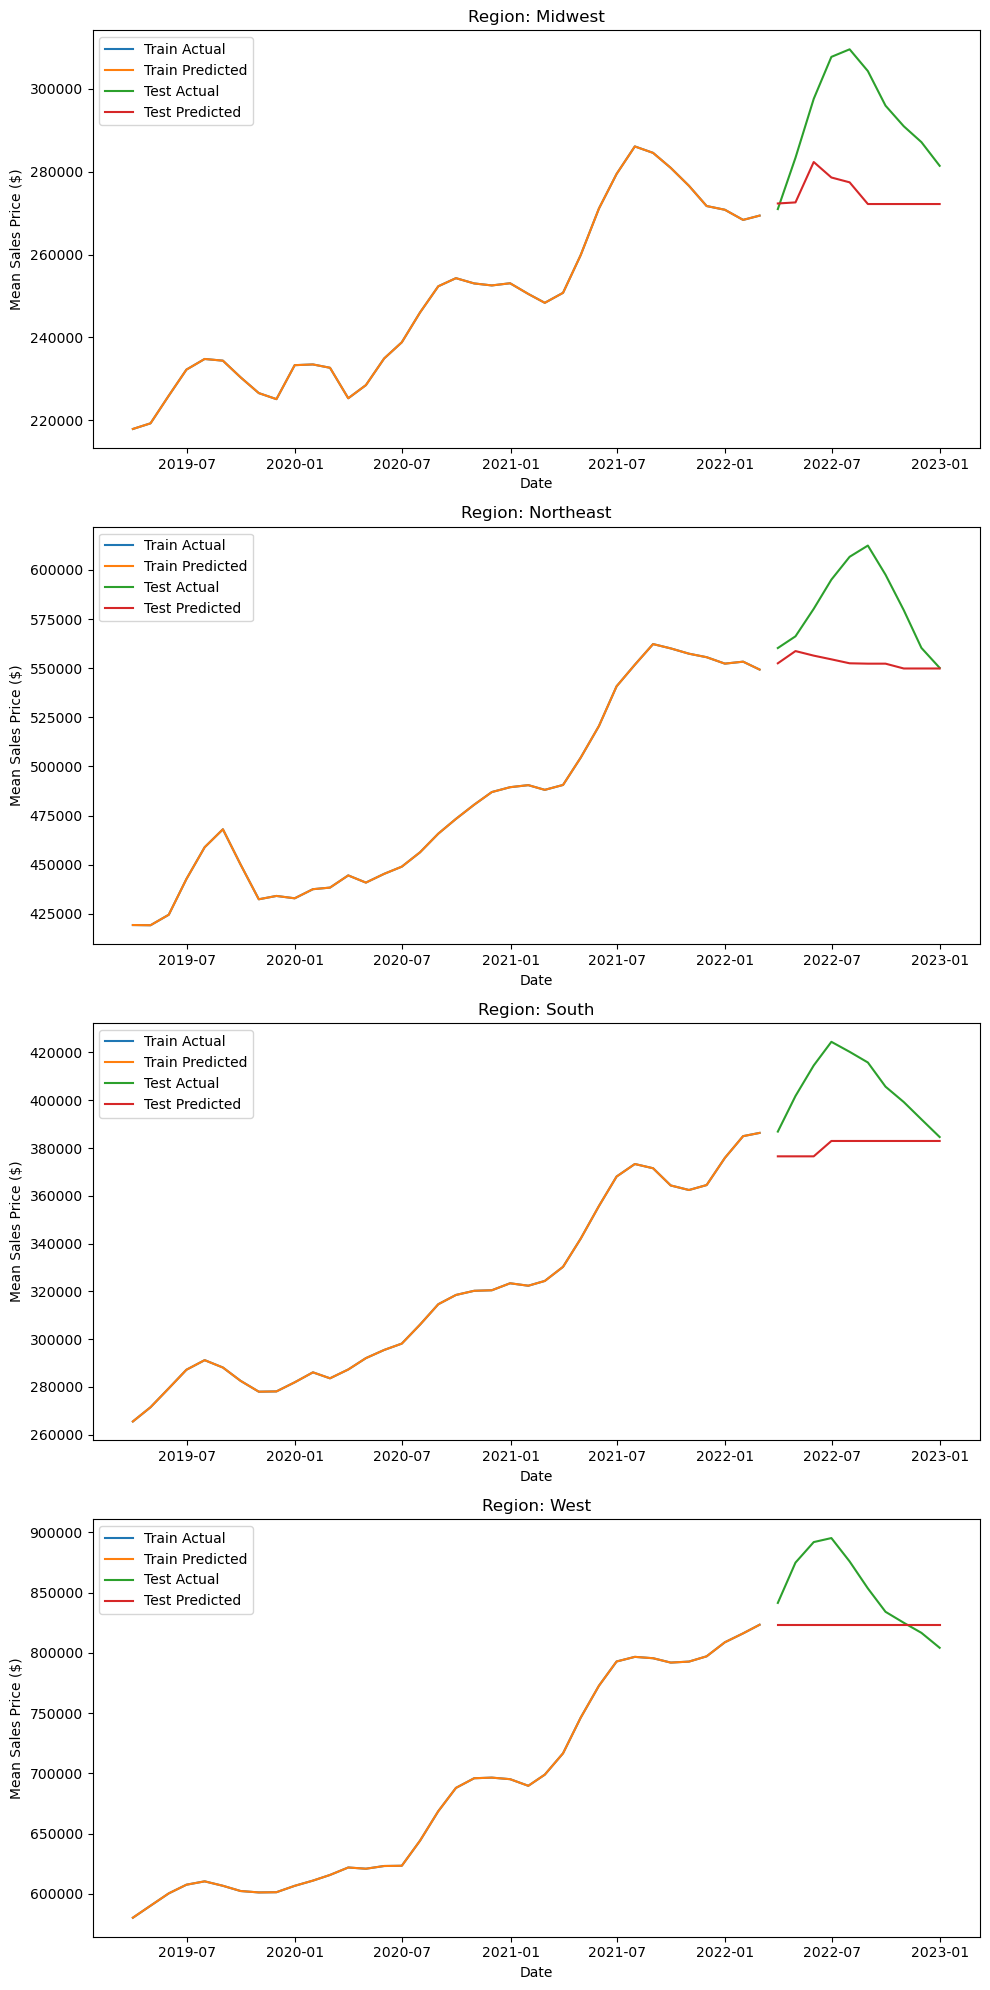

In [7]:
import xgboost as xgb

# Function to create lag features and remove non-numeric columns
def create_lag_features(data, target_column, lags=12):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df.dropna(inplace=True)
    return df

# Initialize a dictionary to store results for XGBoost model
xgb_simple_results = {}

# Parameters
lags = 12
test_size = 0.2
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 50  # Reduced number of estimators
}

for region in regions:
    region_data = data_filtered_mean_sales[data_filtered_mean_sales['region'] == region].copy()
    region_data.set_index('date', inplace=True)
    
    # Create lag features
    region_data_lagged = create_lag_features(region_data, target_column='w_mean sales price ($)', lags=lags)
    
    # Split data into features and target
    X = region_data_lagged.drop(['w_mean sales price ($)', 'region'], axis=1)
    y = region_data_lagged['w_mean sales price ($)']
    
    # Split data into training and test sets
    train_size = int(len(region_data_lagged) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Initialize and train the model
    model = xgb.XGBRegressor(**model_params)
    model.fit(X_train, y_train)
    
    # Make forecasts
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Store results
    xgb_simple_results[region] = {
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'X_train': X_train.index,
        'X_test': X_test.index
    }

# Plot results for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 5 * len(regions)))
if len(regions) == 1:
    axes = [axes]

for ax, region in zip(axes, regions):
    result = xgb_simple_results[region]
    ax.plot(result['X_train'], result['y_train'], label='Train Actual')
    ax.plot(result['X_train'], result['y_pred_train'], label='Train Predicted')
    ax.plot(result['X_test'], result['y_test'], label='Test Actual')
    ax.plot(result['X_test'], result['y_pred_test'], label='Test Predicted')
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sales Price ($)')
    ax.legend()

plt.tight_layout()
plt.show()


### Models with Economics Variables

/var/folders/n4/gxgjq2d52n1gzz_0x_mtj72r0000gn/T/ipykernel_89532/4273823957.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_mean_sales['date'] = pd.to_datetime(data_filtered_mean_sales['date'])


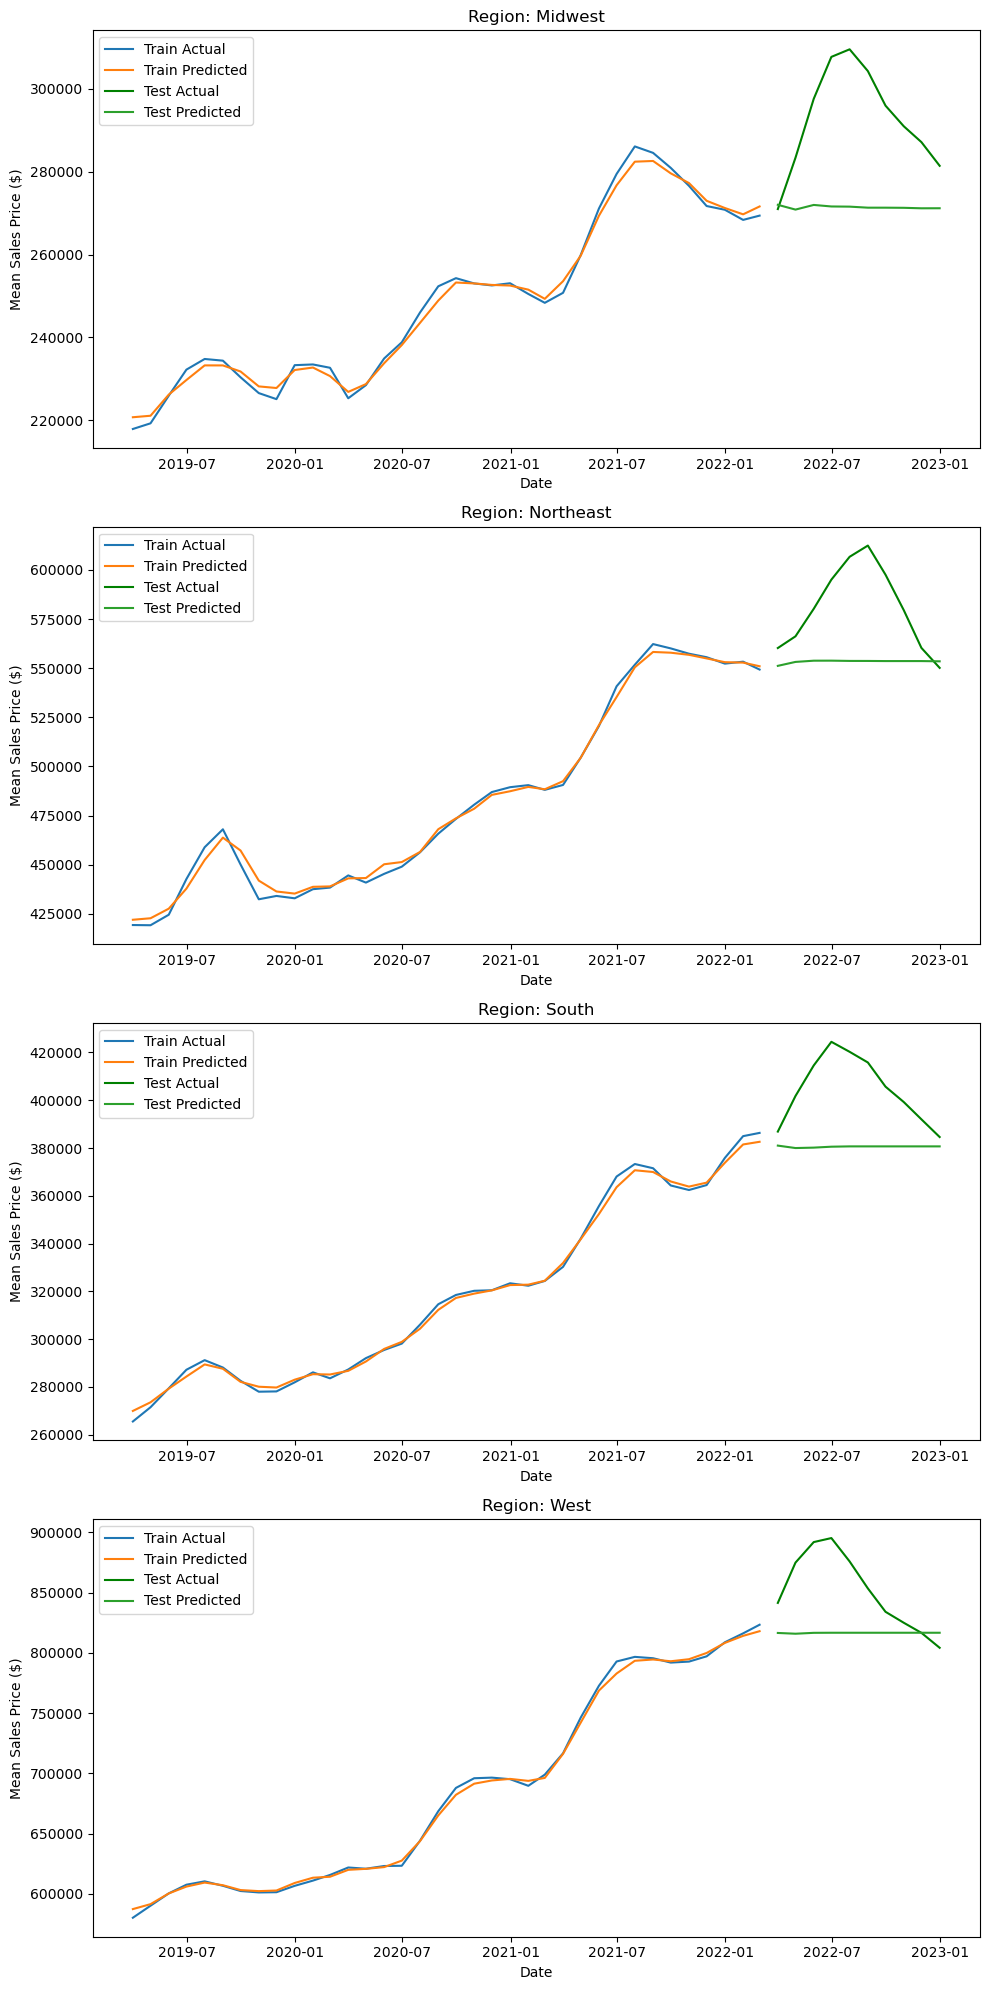

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Include external variables in the dataset
data_filtered_mean_sales = data[['region', 'date', 'w_mean sales price ($)', 'Population', 'w_PCPI', 'MORTGAGE30US']]
data_filtered_mean_sales['date'] = pd.to_datetime(data_filtered_mean_sales['date'])

# Function to create lag features and include external variables
def create_lag_features_with_externals(data, target_column, externals, lags=12):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df.dropna(inplace=True)
    return df

# Initialize a dictionary to store results for Random Forest model
rf_results_with_externals = {}

# Parameters
lags = 12
test_size = 0.2

for region in regions:
    region_data = data_filtered_mean_sales[data_filtered_mean_sales['region'] == region].copy()
    region_data.set_index('date', inplace=True)
    
    # Create lag features and include external variables
    region_data_lagged = create_lag_features_with_externals(region_data, target_column='w_mean sales price ($)', externals=['Population', 'w_PCPI', 'MORTGAGE30US'], lags=lags)
    
    # Split data into features and target
    X = region_data_lagged.drop(['w_mean sales price ($)', 'region'], axis=1)
    y = region_data_lagged['w_mean sales price ($)']
    
    # Split data into training and test sets
    train_size = int(len(region_data_lagged) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    
    # Make forecasts
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Store results
    rf_results_with_externals[region] = {
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'X_train': X_train.index,
        'X_test': X_test.index
    }

# Plot results for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 5 * len(regions)))
if len(regions) == 1:
    axes = [axes]

for ax, region in zip(axes, regions):
    result = rf_results_with_externals[region]
    ax.plot(result['X_train'], result['y_train'], label='Train Actual')
    ax.plot(result['X_train'], result['y_pred_train'], label='Train Predicted')
    ax.plot(result['X_test'], result['y_test'], label='Test Actual', color='green')
    ax.plot(result['X_test'], result['y_pred_test'], label='Test Predicted')
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sales Price ($)')
    ax.legend()

plt.tight_layout()
plt.show()


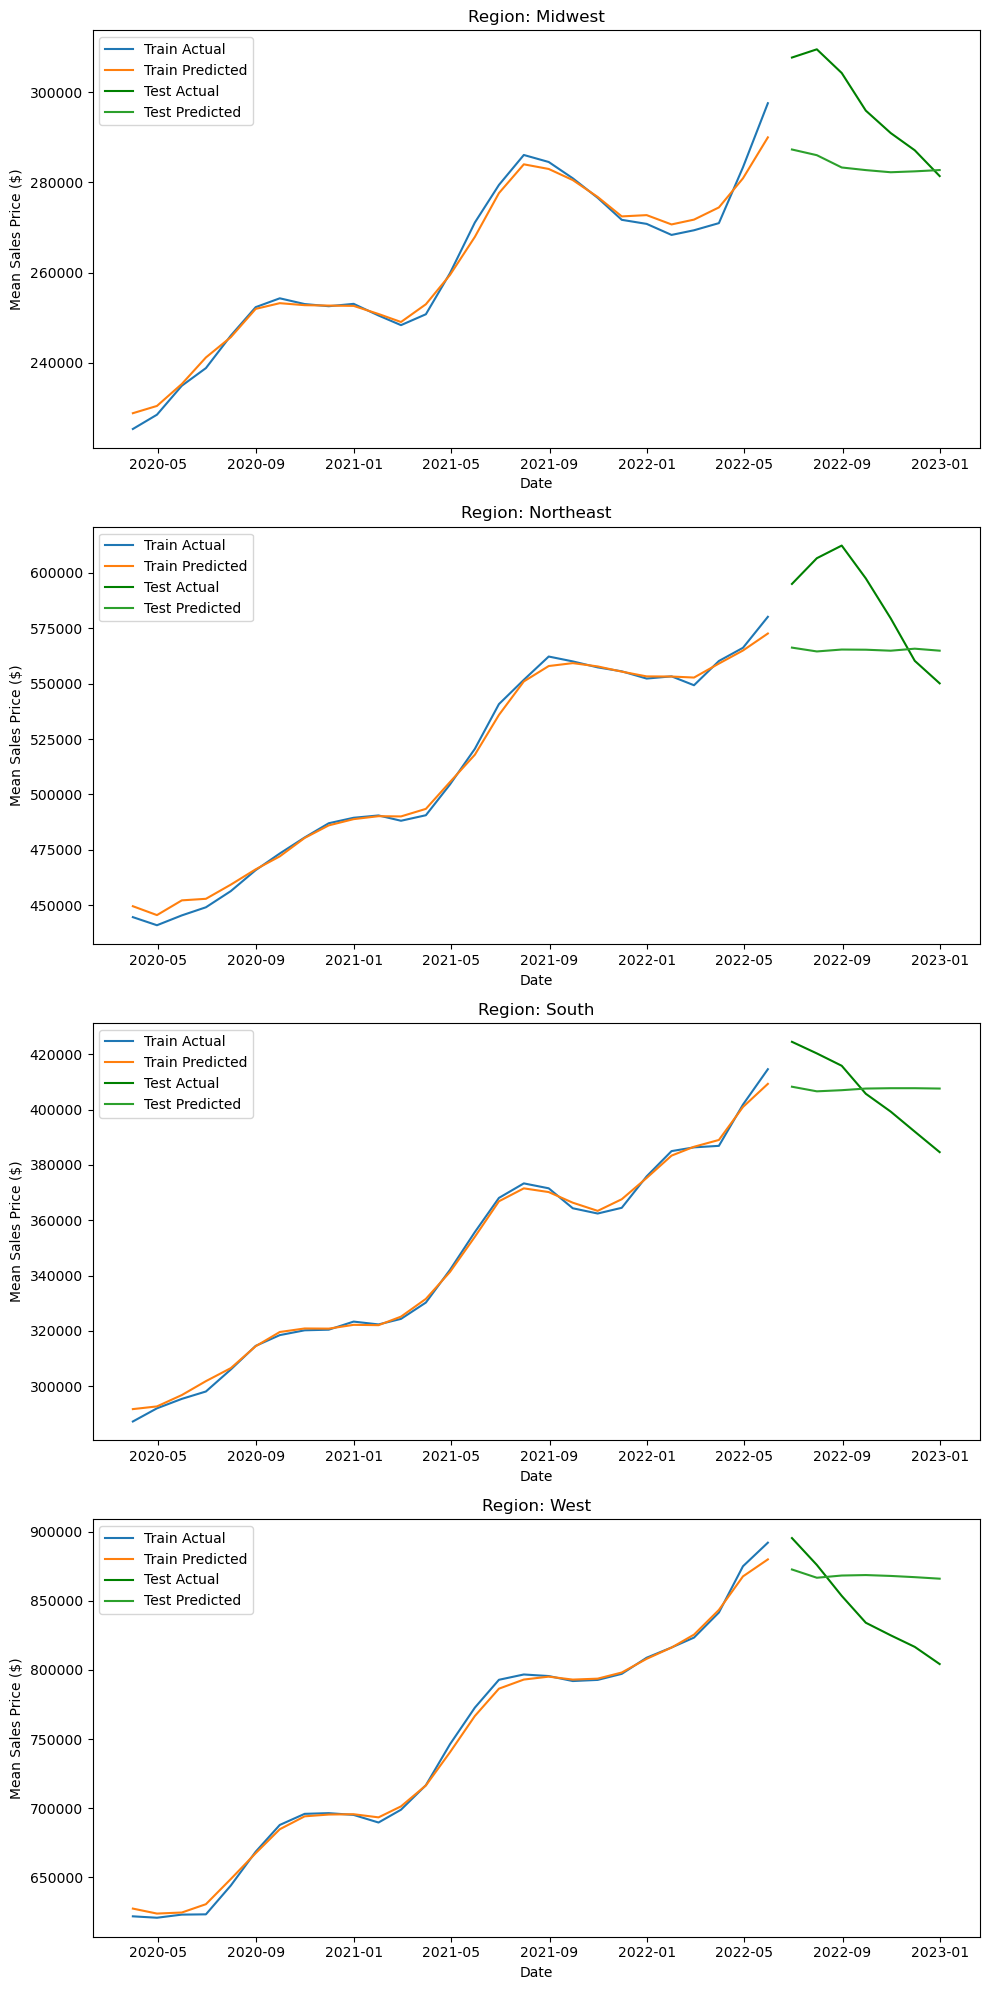

Best parameters for region Midwest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for region Northeast: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for region South: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for region West: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [9]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Increase the number of lags and tune the hyperparameters using cross-validation
lags = 24  # Increase the number of lags
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize a dictionary to store results for the improved Random Forest model
rf_improved_results = {}

for region in regions:
    region_data = data_filtered_mean_sales[data_filtered_mean_sales['region'] == region].copy()
    region_data.set_index('date', inplace=True)
    
    # Create lag features and include external variables
    region_data_lagged = create_lag_features_with_externals(region_data, target_column='w_mean sales price ($)', externals=['Population', 'w_PCPI', 'MORTGAGE30US'], lags=lags)
    
    # Split data into features and target
    X = region_data_lagged.drop(['w_mean sales price ($)', 'region'], axis=1)
    y = region_data_lagged['w_mean sales price ($)']
    
    # Split data into training and test sets
    train_size = int(len(region_data_lagged) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Cross-validation for hyperparameter tuning
    tscv = TimeSeriesSplit(n_splits=5)
    model = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make forecasts
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Store results
    rf_improved_results[region] = {
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'X_train': X_train.index,
        'X_test': X_test.index,
        'best_params': grid_search.best_params_
    }

# Plot results for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 5 * len(regions)))
if len(regions) == 1:
    axes = [axes]

for ax, region in zip(axes, regions):
    result = rf_improved_results[region]
    ax.plot(result['X_train'], result['y_train'], label='Train Actual')
    ax.plot(result['X_train'], result['y_pred_train'], label='Train Predicted')
    ax.plot(result['X_test'], result['y_test'], label='Test Actual', color='green')
    ax.plot(result['X_test'], result['y_pred_test'], label='Test Predicted')
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sales Price ($)')
    ax.legend()

plt.tight_layout()
plt.show()

# Output best parameters for each region
for region in regions:
    print(f"Best parameters for region {region}: {rf_improved_results[region]['best_params']}")



/var/folders/n4/gxgjq2d52n1gzz_0x_mtj72r0000gn/T/ipykernel_89532/731414803.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_mean_sales['date'] = pd.to_datetime(data_filtered_mean_sales['date'])


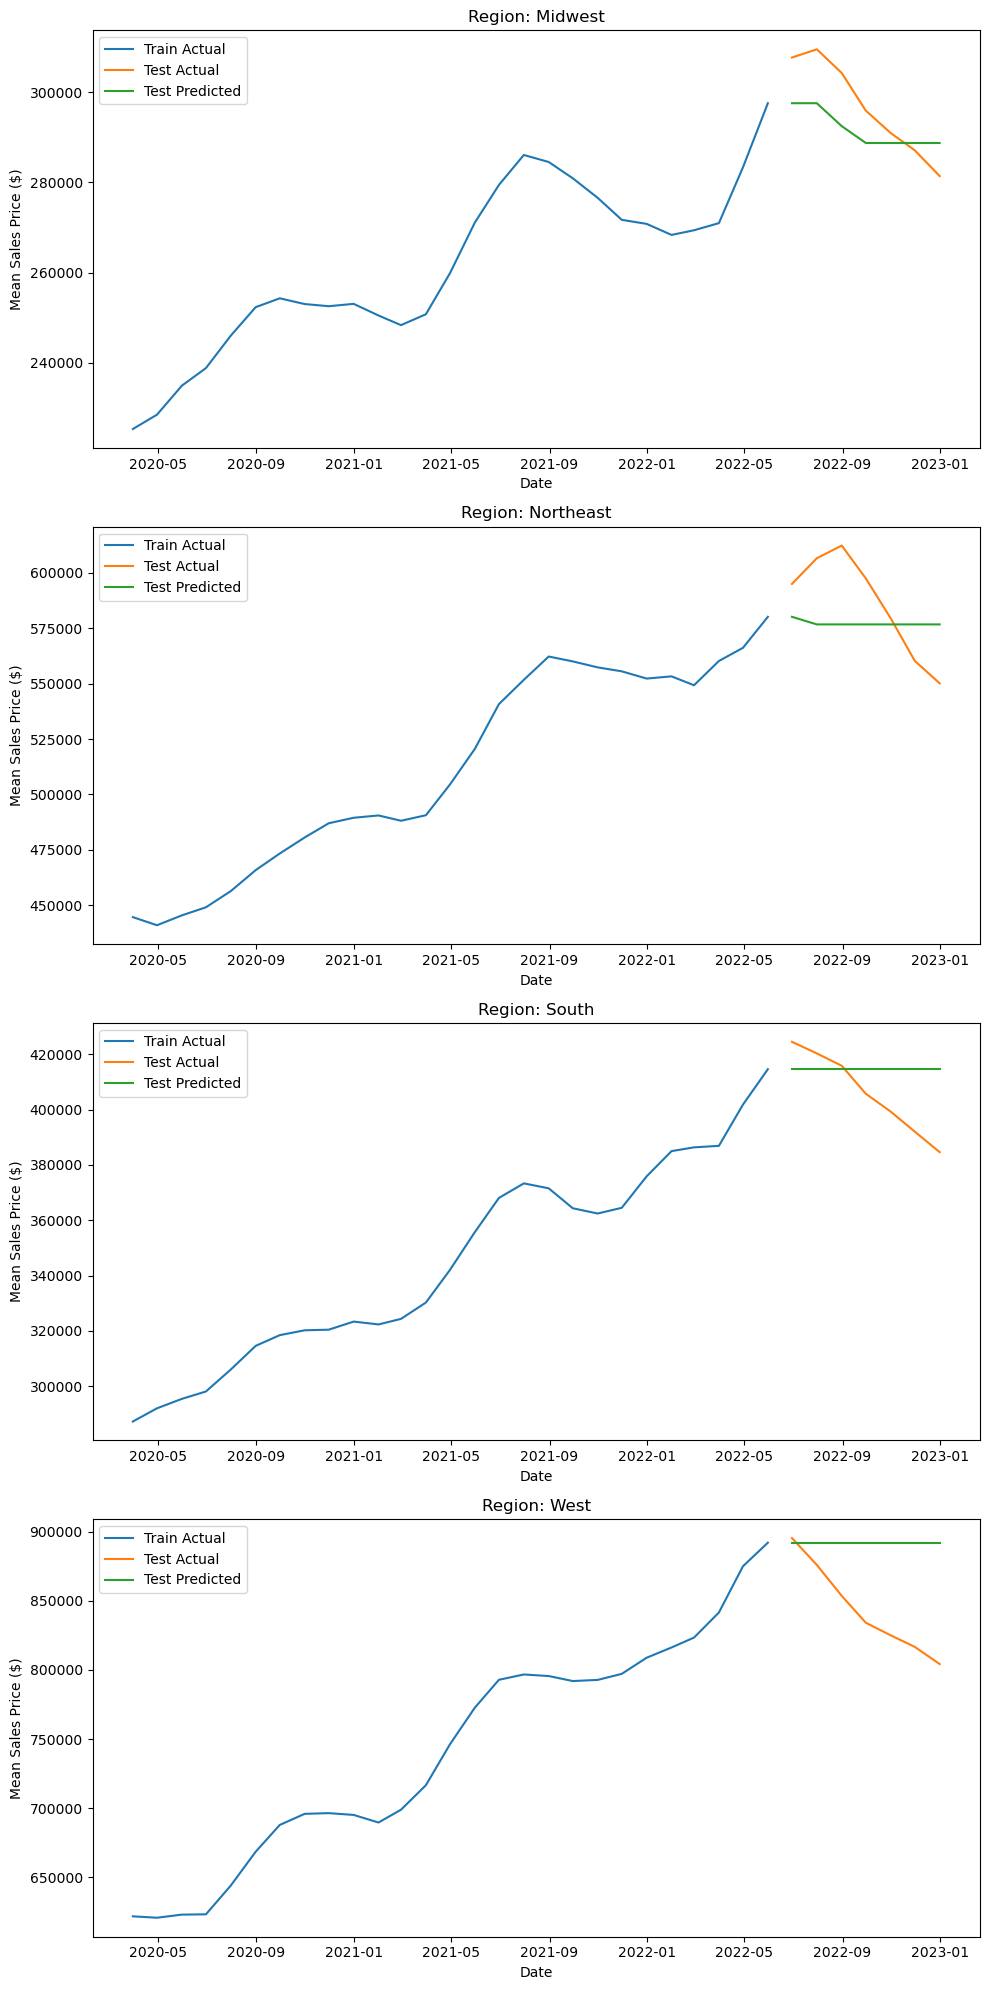

In [15]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# reload the data
weighted_regional = ld.regional_grouped_data
weighted_regional = weighted_regional.reset_index()
weighted_regional
data = weighted_regional
data

# Filter relevant columns
data_filtered_mean_sales = data[['region', 'date', 'w_mean sales price ($)', 'Population', 'w_PCPI', 'MORTGAGE30US']]
data_filtered_mean_sales['date'] = pd.to_datetime(data_filtered_mean_sales['date'])

# Function to create lag features and include external variables
def create_lag_features_with_externals(data, target_column, externals, lags=12):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df.dropna(inplace=True)
    return df

# Initialize a dictionary to store results for the XGBoost model
xgb_results_with_externals = {}

# Parameters
lags = 24  # Increase the number of lags
test_size = 0.2

for region in regions:
    region_data = data_filtered_mean_sales[data_filtered_mean_sales['region'] == region].copy()
    region_data.set_index('date', inplace=True)
    
    # Create lag features and include external variables
    region_data_lagged = create_lag_features_with_externals(region_data, target_column='w_mean sales price ($)', externals=['Population', 'w_PCPI', 'MORTGAGE30US'], lags=lags)
    
    # Split data into features and target
    X = region_data_lagged.drop(['w_mean sales price ($)', 'region'], axis=1)
    y = region_data_lagged['w_mean sales price ($)']
    
    # Split data into training and test sets
    train_size = int(len(region_data_lagged) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Initialize and train the model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    
    # Make forecasts
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Store results
    xgb_results_with_externals[region] = {
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'X_train': X_train.index,
        'X_test': X_test.index
    }

# Plot results for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 5 * len(regions)))
if len(regions) == 1:
    axes = [axes]

for ax, region in zip(axes, regions):
    result = xgb_results_with_externals[region]
    ax.plot(result['X_train'], result['y_train'], label='Train Actual')
    # ax.plot(result['X_train'], result['y_pred_train'], label='Train Predicted')
    ax.plot(result['X_test'], result['y_test'], label='Test Actual')
    ax.plot(result['X_test'], result['y_pred_test'], label='Test Predicted')
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sales Price ($)')
    ax.legend()

plt.tight_layout()
plt.show()
